# STEP 2 - COMBINE ALL RISK FACTORS

##### Created by - Sanjana Tule 
##### Date - 14/08/2021


This code integrates the risk factors and the neighbourhoods for downstream path finding algorithm

1.   Choose pickles files to combine the risk factors into 1 graph
2.   Combine the neighbourhoods
3.   Add nodes for parks and evacuation sites


Different Risk Factors:

1. Distance Risk - raw values , higher values means high risk and lower value means low risk
2. Speed Risk - speed is either 6,7,8,9. Higher the value means higher risk as speed is low in that zone.
3. Density Risk - raw values, higher density means lots of buildings and higher risk
4. Liquification Risk - values either 0/1. 0 means no liquification and hence safe area. 1 means not so safe.
4. Width Risk - values between 0 and 5. 5 means less width and hence more risk. 0 means high width and less risk.



In [1]:
# !pip install osmnx
# !apt install python3-rtree

In [16]:
import osmnx as ox
import networkx as nx
import numpy as np
import geopandas
import matplotlib.pyplot as plt
from geopy.geocoders import Nominatim
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
import matplotlib

In [4]:
# mount google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


STEP 1 - COMBINE ALL RISK FACTORS - 
DISTANCE RISK, 
MAX SPEED LIMIT RISK, 
BUILDING DENSITY RISK 
FOR EACH OF THE 3 NEIGHBOURHOODS - NORTHRIDGE, NORTH HILLS AND CHATSWORTH

In [12]:
# STEP 1 - COMBINE RISK FACTORS FOR ALL NEIGHBOURHOODS

# --- NORTHRIDGE, CHATSWORTH AND NORTH HILLS --- #
for n in ['northridge','chatsworth','northhills']:
#for n in ['northridge']:
  print("Processing neighbourhood:", n)

  distance_risk_score_file_name = '/content/drive/My Drive/omdena/earthquake/1_1_' +  str(n) + '_graph_distance_risk_added.pickle'
  density_risk_score_file_name  = '/content/drive/My Drive/omdena/earthquake/1_2_' +  str(n) + '_graph_building_density_risk_addded.pickle'
  speed_risk_score_file_name    = '/content/drive/My Drive/omdena/earthquake/1_3_' +  str(n) + '_graph_speed_risk_added.pickle'
  width_risk_score_file_name    = '/content/drive/My Drive/omdena/earthquake/1_2_' +  str(n) + '_graph_width_added.pickle'
  liq_risk_score_file_name      = '/content/drive/My Drive/omdena/earthquake/1_2_' +  str(n) + '_graph_liq_addded.pickle'
  combined_risk_file_name       = '/content/drive/My Drive/omdena/earthquake/1_' +  str(n) + '_graph_all_risk_added.pickle'

  # RISK FACTOR 1. distance pickle
  graph_distance = nx.read_gpickle(distance_risk_score_file_name)
  nodes_distance,edges_distance = ox.graph_to_gdfs(graph_distance)

  # RISK FACTOR 2. building density pickle
  density_pickle = nx.read_gpickle(density_risk_score_file_name)
  nodes_bd,edges_bd = ox.graph_to_gdfs(density_pickle)
  
  # RISK FACTOR 3. speed limit pickle
  speed_pickle = nx.read_gpickle(speed_risk_score_file_name)
  nodes_sp,edges_sp = ox.graph_to_gdfs(speed_pickle)  

  # RISK FACTOR 4. road width pickle
  road_width_pickle = nx.read_gpickle(width_risk_score_file_name)
  nodes_w,edges_w = ox.graph_to_gdfs(road_width_pickle)

  # RISK FACTOR 5. liquification pickle
  liq_pickle = nx.read_gpickle(liq_risk_score_file_name)
  nodes_l,edges_l = ox.graph_to_gdfs(liq_pickle)

  # remove extra columns
  edges_distance['distance_risk_score'] = edges_distance['max']
  edges_distance = edges_distance.drop(columns = ['sampling_counts','max','min','median','x_y','lon_lat','mean_scaled','mean','median_scaled','mean_scaled_inversed','median_scaled_inversed'])
  edges_sp = edges_sp.drop(columns=['name','highway','oneway','length','lanes','access','ref','service','bridge','width','tunnel','maxspeed'])
  edges_bd = edges_bd.drop(columns=['name','highway','maxspeed','oneway','length','lanes','access','ref','service','bridge','width','tunnel'])
  edges_bd = edges_bd.rename(columns={"Building": "density_risk_score"})
  edges_w = edges_w.drop(columns=['name','highway','maxspeed','oneway','length','lanes','access','ref','service','bridge','tunnel','width'])
  edges_l = edges_l.drop(columns=['name','highway','maxspeed','oneway','length','lanes','access','ref','service','bridge','tunnel'])
  edges_l = edges_l.rename(columns={"liq_zone": "liq_risk_score"})
  
  # remove duplicates
  edges_distance = edges_distance[~edges_distance.index.duplicated(keep='first')]
  edges_sp = edges_sp[~edges_sp.index.duplicated(keep='first')]
  edges_bd = edges_bd[~edges_bd.index.duplicated(keep='first')]
  edges_w = edges_w[~edges_w.index.duplicated(keep='first')]
  edges_l = edges_l[~edges_l.index.duplicated(keep='first')]


  # join edges dataframe on index
  combine_1 = edges_distance.join(edges_sp,lsuffix='_org', rsuffix='_other')
  combine_2 = combine_1.join(edges_bd,lsuffix='_org', rsuffix='_other')
  combine_3 = combine_2.join(edges_w,lsuffix='_org', rsuffix='_other')
  combined_risk_edges = combine_3.join(edges_l,lsuffix='_org', rsuffix='_other')

  #display(combined_risk_edges.head())

  # drop duplicate columns
  keep_columns = ['osmid','name','highway','oneway','length','geometry','lanes','access','ref','service','bridge','tunnel','distance_risk_score','max_speed_risk_score','density_risk_score','width_risk_score','liq_risk_score']
  combined_risk_edges = combined_risk_edges[keep_columns]

  display(combined_risk_edges.head())

  # Create a new graph and save in pickle file
  combined_risk_graph = ox.graph_from_gdfs(nodes_distance, combined_risk_edges)
  nx.write_gpickle(combined_risk_graph, combined_risk_file_name)

Processing neighbourhood: northridge


osmid  ... liq_risk_score
u          v          key             ...               
29409715   6403348096 0     15240187  ...            1.0
           6403348099 0    400864506  ...            1.0
           6403348105 0    400864518  ...            1.0
6403348096 29409715   0     15240187  ...            1.0
           4269165902 0     15240187  ...            1.0

[5 rows x 17 columns]

Processing neighbourhood: chatsworth


osmid  ... liq_risk_score
u          v          key                          ...               
21569692   6784129514 0                 401489877  ...              1
           6784129512 0                 401489883  ...              1
           4682380491 0    [185913115, 401489878]  ...              1
6784129514 21569692   0                 401489877  ...              1
           6784129515 0                 829194684  ...              1

[5 rows x 17 columns]

Processing neighbourhood: northhills


osmid  ... liq_risk_score
u          v          key                          ...               
35498901   3835224570 0                 761380461  ...              0
           122650797  0    [405318798, 405318791]  ...              0
3835224570 3835218815 0                 761380461  ...              0
           3835224574 0    [910112053, 405318799]  ...              0
122650797  4059333610 0                  13293162  ...              0

[5 rows x 17 columns]

STEP 2 - COMBINE ALL THE 3 NEIGHBOURHOODS - NORTHRIDGE, NORTH HILLS AND CHATSWORTH

Combining : chatsworth
Combining : northhills


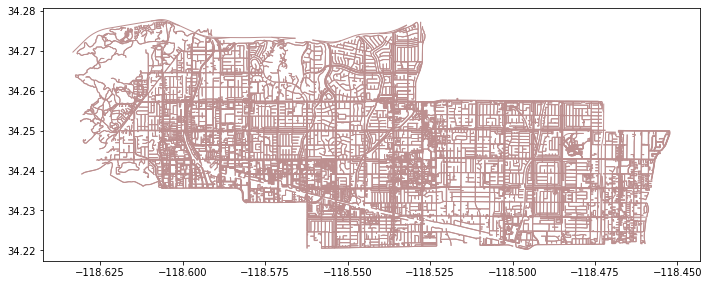

In [13]:
# STEP 2 - COMBINE NEIGHBOURHOODS

all_neighbourhood = '/content/drive/My Drive/omdena/earthquake/1_all_graph_all_risk_added.pickle'
all_neighbourhood_gdf = '/content/drive/My Drive/omdena/earthquake/1_all_graph_gdf.pickle'

combined_risk_file_name       = '/content/drive/My Drive/omdena/earthquake/1_northridge_graph_all_risk_added.pickle'
graph_distance = nx.read_gpickle(combined_risk_file_name)
nodes_all,edges_all= ox.graph_to_gdfs(graph_distance)

for n in ['chatsworth','northhills']:
  print("Combining :",n)
  combined_risk_file_name       = '/content/drive/My Drive/omdena/earthquake/1_' +  str(n) + '_graph_all_risk_added.pickle'
  
  graph_distance = nx.read_gpickle(combined_risk_file_name)
  nodes_app,edges_app= ox.graph_to_gdfs(graph_distance)

  nodes_all = nodes_all.append(nodes_app)
  edges_all = edges_all.append(edges_app)
 

# remove duplicates if any
edges_all = edges_all[~edges_all.index.duplicated(keep='first')]
nodes_all = nodes_all[~nodes_all.index.duplicated(keep='first')]

# normalise speed columns
edges_all['max_speed_risk_score'] = (edges_all['max_speed_risk_score'] - edges_all['max_speed_risk_score'].min()) / (edges_all['max_speed_risk_score'].max() - edges_all['max_speed_risk_score'].min())

# reverse the distance risk score
edges_all['max'] = edges_all['distance_risk_score']
edges_all['distance_risk_score'] = edges_all['distance_risk_score'].apply(lambda x: abs(x - edges_all['distance_risk_score'].max()))
# normalise distance columns
edges_all['distance_risk_score'] = (edges_all['distance_risk_score'] - edges_all['distance_risk_score'].min()) / (edges_all['distance_risk_score'].max() - edges_all['distance_risk_score'].min())

# normalise density columns
edges_all['density_risk_score'] = (edges_all['density_risk_score'] - edges_all['density_risk_score'].min()) / (edges_all['density_risk_score'].max() - edges_all['density_risk_score'].min())

# normalise width columns
edges_all['width_risk_score'] = (edges_all['width_risk_score'] - edges_all['width_risk_score'].min()) / (edges_all['width_risk_score'].max() - edges_all['width_risk_score'].min())

nodes_all_ = geopandas.GeoDataFrame(nodes_all,geometry='geometry')
edges_all_ = geopandas.GeoDataFrame(edges_all,geometry='geometry')

# create a graph from all nodes and edges
graph_all = ox.graph_from_gdfs(nodes_all_,edges_all_)

# visualise graph
nodes,edges = ox.graph_to_gdfs(graph_all)
fig, ax = plt.subplots(figsize=(10, 10))
edges.plot(ax=ax, linewidth=1,edgecolor='#BC8F8F')
fig.tight_layout()

In [7]:
# VIEW THE RISK FACTORS ON COMBINED GRAPH
edges.head()

osmid           name  ... bridge  tunnel
u          v          key                            ...               
29409715   6403348096 0     15240187   Chase Street  ...    NaN     NaN
           6403348099 0    400864506  Corbin Avenue  ...    NaN     NaN
           6403348105 0    400864518  Corbin Avenue  ...    NaN     NaN
6403348096 29409715   0     15240187   Chase Street  ...    NaN     NaN
           4269165902 0     15240187   Chase Street  ...    NaN     NaN

[5 rows x 17 columns]

STEP 3 - ADD NEAREST NODES FOR PARKS FOR EVACUATION SITES


In [8]:
# STEP 3 - ADD PARK NODES FOR DOWNSTREAM APP

warnings.filterwarnings("ignore")
geolocator = Nominatim(user_agent="Nominatim")
nodes['evacuation_flag'] = 'N'
nodes['evacuation_name'] = 'NA'

# get all parks in 3 neighbourhoods
for n in ['northridge','chatsworth','north hills']:
  print("Processing parks in neighbourhood:", n)
  place = str(n) + ", California, USA"
  parks = ox.geometries_from_place(place, {"leisure":"park"})

  for osmnid,park_details in parks.iterrows():
    if not pd.isnull(park_details['name']):
      
      # find the park lat/lon
      park_address = park_details['name'] + ', ' + str(n) + ", California, USA"
      #print("park address",park_address)

      park_latlon = geolocator.geocode(park_address)
      park_point = (park_latlon.latitude, park_latlon.longitude)
      #print(park_point)
      
      # find the nearest node
      source_node = ox.get_nearest_node(graph_all,park_point,return_dist=False)
      #source_node = ox.distance.nearest_nodes(graph_all,park_point[0],park_point[1],return_dist=False)
      #print("source node found.source node:",source_node)
      
      # add evacuation site on that node.
      nodes.loc[(source_node),'evacuation_name'] = park_details['name']
      nodes.loc[(source_node),'evacuation_flag'] = 'Y'
      nodes.loc[(source_node),'evacuation_type'] = 'park'


Processing parks in neighbourhood: northridge


/usr/local/lib/python3.7/dist-packages/osmnx/distance.py:356: UserWarning: The `get_nearest_node` function has been deprecated and will be removed in a future release. Use the more efficient `distance.nearest_nodes` instead.
  warnings.warn(msg)
/usr/local/lib/python3.7/dist-packages/osmnx/distance.py:356: UserWarning: The `get_nearest_node` function has been deprecated and will be removed in a future release. Use the more efficient `distance.nearest_nodes` instead.
  warnings.warn(msg)
/usr/local/lib/python3.7/dist-packages/osmnx/distance.py:356: UserWarning: The `get_nearest_node` function has been deprecated and will be removed in a future release. Use the more efficient `distance.nearest_nodes` instead.
  warnings.warn(msg)
/usr/local/lib/python3.7/dist-packages/osmnx/distance.py:356: UserWarning: The `get_nearest_node` function has been deprecated and will be removed in a future release. Use the more efficient `distance.nearest_nodes` instead.
  warnings.warn(msg)
/usr/local/lib/p

Processing parks in neighbourhood: chatsworth


/usr/local/lib/python3.7/dist-packages/osmnx/distance.py:356: UserWarning: The `get_nearest_node` function has been deprecated and will be removed in a future release. Use the more efficient `distance.nearest_nodes` instead.
  warnings.warn(msg)
/usr/local/lib/python3.7/dist-packages/osmnx/distance.py:356: UserWarning: The `get_nearest_node` function has been deprecated and will be removed in a future release. Use the more efficient `distance.nearest_nodes` instead.
  warnings.warn(msg)
/usr/local/lib/python3.7/dist-packages/osmnx/distance.py:356: UserWarning: The `get_nearest_node` function has been deprecated and will be removed in a future release. Use the more efficient `distance.nearest_nodes` instead.
  warnings.warn(msg)
/usr/local/lib/python3.7/dist-packages/osmnx/distance.py:356: UserWarning: The `get_nearest_node` function has been deprecated and will be removed in a future release. Use the more efficient `distance.nearest_nodes` instead.
  warnings.warn(msg)
/usr/local/lib/p

Processing parks in neighbourhood: north hills


/usr/local/lib/python3.7/dist-packages/osmnx/distance.py:356: UserWarning: The `get_nearest_node` function has been deprecated and will be removed in a future release. Use the more efficient `distance.nearest_nodes` instead.
  warnings.warn(msg)
/usr/local/lib/python3.7/dist-packages/osmnx/distance.py:356: UserWarning: The `get_nearest_node` function has been deprecated and will be removed in a future release. Use the more efficient `distance.nearest_nodes` instead.
  warnings.warn(msg)


In [9]:
display("View Evacuation Nodes",nodes[nodes['evacuation_flag'] == 'Y'])

'View Evacuation Nodes'

,y,x,highway,street_count,ref,geometry,evacuation_flag,evacuation_name,evacuation_type
osmid,,,,,,,,,
4036602793,34.269342,-118.555279,NaN,3,NaN,POINT (-118.55528 34.26934),Y,Limekiln Canyon Park,park
367962589,34.238741,-118.508881,NaN,3,NaN,POINT (-118.50888 34.23874),Y,Dearborn Park,park
4569962917,34.239471,-118.529319,NaN,3,NaN,POINT (-118.52932 34.23947),Y,Oviatt Lawn,park
4636164573,34.253069,-118.533800,NaN,3,NaN,POINT (-118.53380 34.25307),Y,Northridge Park,park
6027909235,34.233205,-118.547530,NaN,1,NaN,POINT (-118.54753 34.23321),Y,Vanalden Park,park
6522417630,34.256775,-118.540027,NaN,1,NaN,POINT (-118.54003 34.25677),Y,Oakridge Park,park
6965201863,34.260849,-118.579549,NaN,3,NaN,POINT (-118.57955 34.26085),Y,Mason Park,park
123198975,34.239073,-118.630699,NaN,3,NaN,POINT (-118.63070 34.23907),Y,Chatsworth Oaks Park,park
8813133259,34.264680,-118.612837,NaN,1,NaN,POINT (-118.61284 34.26468),Y,Chatsworth Park North,park


STEP 4 - ADD NEAREST NODES FOR SHELTERS FOR EVACUATION SITES

In [10]:
# STEP 4 - ADD SHELTER NODES FOR DOWNSTREAM APP
warnings.filterwarnings("ignore")
shelterFacilities = geopandas.read_file('/content/drive/My Drive/omdena/earthquake/shelters.geojson.txt')
shelterFacilities.crs = 'epsg:4326'
#display(shelterFacilities['CITY'].unique())

shelterFacilities = shelterFacilities[shelterFacilities['CITY'].isin(['NORTH HILLS','NORTHRIDGE','CHATSWORTH'])]
#display(shelterFacilities.head())

for ind, address in shelterFacilities[['SHELTER_NAME','LATITUDE','LONGITUDE']].iterrows():
  shelter_lat = address['LATITUDE']
  shelter_long = address['LONGITUDE']

  # find the nearest node
  source_node = ox.get_nearest_node(graph_all,(shelter_lat,shelter_long),return_dist=False)
  #print("source node found.source node:",source_node)
      
  # add evacuation site on that node.
  nodes.loc[(source_node),'evacuation_name'] = address['SHELTER_NAME']
  nodes.loc[(source_node),'evacuation_flag'] = 'Y'
  nodes.loc[(source_node),'evacuation_type'] = 'shelter'

In [ ]:
# See all evacuation sites
display("View Evacuation Nodes",nodes[nodes['evacuation_flag'] == 'Y'])

'View Evacuation Nodes'

,y,x,highway,street_count,ref,geometry,evacuation_flag,evacuation_name,evacuation_type
osmid,,,,,,,,,
4036602793,34.269342,-118.555279,NaN,3,NaN,POINT (-118.55528 34.26934),Y,Limekiln Canyon Park,park
122598528,34.239477,-118.515618,NaN,4,NaN,POINT (-118.51562 34.23948),Y,Northridge Academy High School Multipurpose Ro...,shelter
6026697252,34.235366,-118.527487,NaN,3,NaN,POINT (-118.52749 34.23537),Y,CAL STATE NORTHRIDGE,shelter
367962589,34.238741,-118.508881,NaN,3,NaN,POINT (-118.50888 34.23874),Y,Dearborn Park,park
6984443265,34.240783,-118.504347,NaN,3,NaN,POINT (-118.50435 34.24078),Y,Holmes Middle School,shelter
8218477731,34.233104,-118.549200,NaN,3,NaN,POINT (-118.54920 34.23310),Y,Wilkinson Multipurpose Senior Citizen Center,shelter
6027909235,34.233205,-118.547530,NaN,1,NaN,POINT (-118.54753 34.23321),Y,Vanalden Park,park
6412684867,34.250855,-118.553747,NaN,3,NaN,POINT (-118.55375 34.25085),Y,Nobel Middle School,shelter
122720277,34.244964,-118.523305,NaN,3,NaN,POINT (-118.52330 34.24496),Y,Northridge Academy High School Gym 1/2,shelter


In [11]:
# STEP 5 - save graph in pickle files

# create a graph from all nodes and edges
graph_all = ox.graph_from_gdfs(nodes,edges)

# create a new graph and save in pickle file
nx.write_gpickle(graph_all, all_neighbourhood)

# save gdf of the places
place = ['Northridge, California, USA','Chatsworth, California, USA','North Hills, California, USA']
combined_gdf = ox.geocode_to_gdf(place)

all_neighbourhood_gdf = '/content/drive/My Drive/omdena/earthquake/1_all_graph_gdf.pickle'
nx.write_gpickle(combined_gdf,all_neighbourhood_gdf)